## Load package

In [1]:
import logging
import os
import sys
from dataclasses import dataclass, field
from typing import Optional

import torch
from datasets import load_dataset
from PIL import Image
from torchvision.io import ImageReadMode, read_image
from torchvision.transforms import CenterCrop, ConvertImageDtype, Normalize, Resize, ToTensor
from torchvision.transforms.functional import InterpolationMode

import transformers
from transformers import (
    AutoImageProcessor,
    AutoModel,
    AutoTokenizer,
    HfArgumentParser,
    Trainer,
    TrainingArguments,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version, send_example_telemetry
from transformers.utils.versions import require_version

## Initialize sh Args

In [2]:
import argparse

args = argparse.Namespace(
    output_dir='./clip-roberta-finetuned',
    model_name_or_path='../clip-roberta',
    data_dir='/remote-home/songtianwei/research/diffusion_model_my/data',
    dataset_name='ydshieh/coco_dataset_script',
    dataset_config_name='2017',
    image_column='image_path',
    caption_column='caption',
    remove_unused_columns=False,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size='128',
    per_device_eval_batch_size='64',
    learning_rate='5e-5',
    warmup_steps='0',
    weight_decay=0.1,
    overwrite_output_dir=True,
    input_perturbation=0.1,
    dataset_noise_type='clip_min_noise',
    dataset_normalize_flag=False,
    max_train_samples=1000
)

# 使用示例
print(args.output_dir)
print(args.model_name_or_path)
# 打印更多参数...

# 在脚本中可以直接使用args变量来访问命令行参数的值


./clip-roberta-finetuned
../clip-roberta


In [3]:
args_list = [
    '--output_dir', './clip-roberta-finetuned',
    '--model_name_or_path', '/remote-home/songtianwei/research/diffusion_model_my/clip-roberta',
    '--data_dir', '/remote-home/songtianwei/research/diffusion_model_my/data',
    '--dataset_name', 'ydshieh/coco_dataset_script',
    '--dataset_config_name', '2017',
    '--image_column', 'image_path',
    '--caption_column', 'caption',
    '--remove_unused_columns', 'False',
    '--do_train',
    '--do_eval',
    '--per_device_train_batch_size', '128',
    '--per_device_eval_batch_size', '64',
    '--learning_rate', '5e-5',
    '--warmup_steps', '0',
    '--weight_decay', '0.1',
    '--overwrite_output_dir',
    '--dataset_noise_type','clip_min_noise',
    '--dataset_normalize_flag','False',
    '--max_train_samples','100',
]

## Initilize Arguments

In [4]:
logger = logging.getLogger(__name__)

# Will error if the minimal version of Transformers is not installed. Remove at your own risks.
check_min_version("4.31.0.dev0")

require_version("datasets>=1.8.0", "To fix: pip install -r examples/pytorch/contrastive-image-text/requirements.txt")



In [5]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune, or train from scratch.
    """

    model_name_or_path: str = field(
        metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"},
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    image_processor_name: str = field(default=None, metadata={"help": "Name or path of preprocessor config."})
    cache_dir: Optional[str] = field(
        default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
    )
    model_revision: str = field(
        default="main",
        metadata={"help": "The specific model version to use (can be a branch name, tag name or commit id)."},
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={"help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."},
    )
    use_auth_token: bool = field(
        default=False,
        metadata={
            "help": (
                "Will use the token generated when running `huggingface-cli login` (necessary to use this script "
                "with private models)."
            )
        },
    )
    freeze_vision_model: bool = field(
        default=False, metadata={"help": "Whether to freeze the vision model parameters or not."}
    )
    freeze_text_model: bool = field(
        default=False, metadata={"help": "Whether to freeze the text model parameters or not."}
    )


In [6]:

@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """

    dataset_name: Optional[str] = field(
        default=None, metadata={"help": "The name of the dataset to use (via the datasets library)."}
    )
    dataset_config_name: Optional[str] = field(
        default=None, metadata={"help": "The configuration name of the dataset to use (via the datasets library)."}
    )
    data_dir: Optional[str] = field(default=None, metadata={"help": "The data directory containing input files."})
    image_column: Optional[str] = field(
        default="image_path",
        metadata={"help": "The name of the column in the datasets containing the full image file paths."},
    )
    caption_column: Optional[str] = field(
        default="caption",
        metadata={"help": "The name of the column in the datasets containing the image captions."},
    )
    train_file: Optional[str] = field(
        default=None, metadata={"help": "The input training data file (a jsonlines file)."}
    )
    validation_file: Optional[str] = field(
        default=None,
        metadata={"help": "An optional input evaluation data file (a jsonlines file)."},
    )
    test_file: Optional[str] = field(
        default=None,
        metadata={"help": "An optional input testing data file (a jsonlines file)."},
    )
    max_seq_length: Optional[int] = field(
        default=128,
        metadata={
            "help": (
                "The maximum total input sequence length after tokenization. Sequences longer "
                "than this will be truncated, sequences shorter will be padded."
            )
        },
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": (
                "For debugging purposes or quicker training, truncate the number of training examples to this "
                "value if set."
            )
        },
    )
    max_eval_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": (
                "For debugging purposes or quicker training, truncate the number of evaluation examples to this "
                "value if set."
            )
        },
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
    )
    preprocessing_num_workers: Optional[int] = field(
        default=None,
        metadata={"help": "The number of processes to use for the preprocessing."},
    )
    
    # Noise type, default is none, other noise is "random" and "clip_min_noise"
    dataset_noise_type: Optional[str] = field(
        default=None,
        metadata={"help": "The type of noise to add to the dataset."},
    )
    
    dataset_normalize_flag: Optional[bool] = field(
        default=False,
        metadata={"help": "Whether to normalize the dataset."},
    )

    def __post_init__(self):
        if self.dataset_name is None and self.train_file is None and self.validation_file is None:
            raise ValueError("Need either a dataset name or a training/validation file.")
        else:
            if self.train_file is not None:
                extension = self.train_file.split(".")[-1]
                assert extension in ["csv", "json"], "`train_file` should be a csv or a json file."
            if self.validation_file is not None:
                extension = self.validation_file.split(".")[-1]
                assert extension in ["csv", "json"], "`validation_file` should be a csv or a json file."
            if self.validation_file is not None:
                extension = self.validation_file.split(".")[-1]
                assert extension == "json", "`validation_file` should be a json file."


## dataset name mapping

In [7]:
dataset_name_mapping = {
    "image_caption_dataset.py": ("image_path", "caption"),
}

## Transform

In [8]:
class Transform(torch.nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.transforms = torch.nn.Sequential(
            Resize([image_size], interpolation=InterpolationMode.BICUBIC,antialias=None),
            CenterCrop(image_size),
            ConvertImageDtype(torch.float),
            # This is convert tensor image to the given dtype and scale the values accordingly.
            # Normalize(mean, std),
            # ToTensor(),
        )

    def forward(self, x) -> torch.Tensor:
        """`x` should be an instance of `PIL.Image.Image`"""
        with torch.no_grad():
            x = self.transforms(x)
        return x

## Collate_fn

In [46]:
def collate_fn(examples):
    pixel_values = torch.stack([torch.tensor(example["pixel_values"], dtype=torch.long) for example in examples])
    input_ids = torch.tensor([example["input_ids"] for example in examples], dtype=torch.long)
    attention_mask = torch.tensor([example["attention_mask"] for example in examples], dtype=torch.long)
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }

## 1. Parse input arguments
    # See all possible arguments in src/transformers/training_args.py
    # or by passing the --help flag to this script.
    # We now keep distinct sets of args, for a cleaner separation of concerns.

In [47]:
parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
if len(sys.argv) == 2 and sys.argv[1].endswith(".json"):
    # If we pass only one argument to the script and it's the path to a json file,
    # let's parse it to get our arguments.
    model_args, data_args, training_args = parser.parse_json_file(json_file=os.path.abspath(sys.argv[1]))
else:
    print("1")
    model_args, data_args, training_args = parser.parse_args_into_dataclasses(args=args_list)

# Sending telemetry. Tracking the example usage helps us better allocate resources to maintain them. The
# information sent is the one passed as arguments along with your Python/PyTorch versions.
send_example_telemetry("run_clip", model_args, data_args)

[INFO|training_args.py:1283] 2023-07-19 08:05:00,622 >> Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
[INFO|training_args.py:1691] 2023-07-19 08:05:00,624 >> PyTorch: setting up devices
[INFO|training_args.py:1423] 2023-07-19 08:05:00,625 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


1


## 2. Setup logging

In [11]:


logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
)

if training_args.should_log:
    # The default of training_args.log_level is passive, so we set log level at info here to have that default.
    transformers.utils.logging.set_verbosity_info()

log_level = training_args.get_process_log_level()
logger.setLevel(log_level)
transformers.utils.logging.set_verbosity(log_level)
transformers.utils.logging.enable_default_handler()
transformers.utils.logging.enable_explicit_format()

# Log on each process the small summary:
logger.warning(
    f"Process rank: {training_args.local_rank}, device: {training_args.device}, n_gpu: {training_args.n_gpu}"
    + f"distributed training: {bool(training_args.local_rank != -1)}, 16-bits training: {training_args.fp16}"
)
logger.info(f"Training/evaluation parameters {training_args}")


07/19/2023 08:01:00 - WARNING - __main__ - Process rank: 0, device: cuda:0, n_gpu: 1distributed training: True, 16-bits training: False
07/19/2023 08:01:00 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=no,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_config={'fsdp_min_num_params': 0, 'xla': False, 'xla_fsdp_grad_ckpt': False},
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_d


## 3. Detecting last checkpoint and eventualy continue from last checkpoint

In [12]:

last_checkpoint = None
if os.path.isdir(training_args.output_dir) and training_args.do_train and not training_args.overwrite_output_dir:
    last_checkpoint = get_last_checkpoint(training_args.output_dir)
    if last_checkpoint is None and len(os.listdir(training_args.output_dir)) > 0:
        raise ValueError(
            f"Output directory ({training_args.output_dir}) already exists and is not empty. "
            "Use --overwrite_output_dir to overcome."
        )
    elif last_checkpoint is not None and training_args.resume_from_checkpoint is None:
        logger.info(
            f"Checkpoint detected, resuming training at {last_checkpoint}. To avoid this behavior, change "
            "the `--output_dir` or add `--overwrite_output_dir` to train from scratch."
        )

## 4. Load dataset

In [13]:


# Get the datasets: you can either provide your own CSV/JSON training and evaluation files (see below)
# or just provide the name of one of the public datasets available on the hub at https://huggingface.co/datasets/
# (the dataset will be downloaded automatically from the datasets Hub).
#
# For CSV/JSON files this script will use the first column for the full image path and the second column for the
# captions (unless you specify column names for this with the `image_column` and `caption_column` arguments).
#
if data_args.dataset_name is not None:
    # Downloading and loading a dataset from the hub.
    dataset = load_dataset(
        data_args.dataset_name,
        data_args.dataset_config_name,
        cache_dir=model_args.cache_dir,
        keep_in_memory=False,
        data_dir=data_args.data_dir,
        use_auth_token=True if model_args.use_auth_token else None,
    )
else:
    data_files = {}
    if data_args.train_file is not None:
        data_files["train"] = data_args.train_file
        extension = data_args.train_file.split(".")[-1]
    if data_args.validation_file is not None:
        data_files["validation"] = data_args.validation_file
        extension = data_args.validation_file.split(".")[-1]
    if data_args.test_file is not None:
        data_files["test"] = data_args.test_file
        extension = data_args.test_file.split(".")[-1]
    dataset = load_dataset(
        extension,
        data_files=data_files,
        cache_dir=model_args.cache_dir,
        use_auth_token=True if model_args.use_auth_token else None,
    )

07/19/2023 08:01:04 - WARNING - datasets.builder - Found cached dataset coco_dataset_script (/remote-home/songtianwei/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-6f3462d26b47c55a/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f)


  0%|          | 0/3 [00:00<?, ?it/s]

## 5. Load pretrained model, tokenizer, and image processor

In [14]:
if model_args.tokenizer_name:
    tokenizer = AutoTokenizer.from_pretrained(
        model_args.tokenizer_name, cache_dir=model_args.cache_dir, use_fast=model_args.use_fast_tokenizer
    )
elif model_args.model_name_or_path:
    tokenizer = AutoTokenizer.from_pretrained(
        model_args.model_name_or_path, cache_dir=model_args.cache_dir, use_fast=model_args.use_fast_tokenizer
    )
else:
    raise ValueError(
        "You are instantiating a new tokenizer from scratch. This is not supported by this script."
        "You can do it from another script, save it, and load it from here, using --tokenizer_name."
    )

[INFO|tokenization_utils_base.py:1842] 2023-07-19 08:01:05,257 >> loading file vocab.json
[INFO|tokenization_utils_base.py:1842] 2023-07-19 08:01:05,259 >> loading file merges.txt
[INFO|tokenization_utils_base.py:1842] 2023-07-19 08:01:05,259 >> loading file tokenizer.json
[INFO|tokenization_utils_base.py:1842] 2023-07-19 08:01:05,260 >> loading file added_tokens.json
[INFO|tokenization_utils_base.py:1842] 2023-07-19 08:01:05,260 >> loading file special_tokens_map.json
[INFO|tokenization_utils_base.py:1842] 2023-07-19 08:01:05,261 >> loading file tokenizer_config.json


In [15]:
# Load image_processor, in this script we only use this to get the mean and std for normalization.
image_processor = AutoImageProcessor.from_pretrained(
    model_args.image_processor_name or model_args.model_name_or_path,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)

[INFO|image_processing_utils.py:337] 2023-07-19 08:01:05,343 >> loading configuration file /remote-home/songtianwei/research/diffusion_model_my/clip-roberta/preprocessor_config.json
[INFO|image_processing_utils.py:389] 2023-07-19 08:01:05,359 >> Image processor CLIPImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_processor_type": "CLIPImageProcessor",
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "processor_class": "VisionTextDualEncoderProcessor",
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}



In [16]:
model = AutoModel.from_pretrained(
    model_args.model_name_or_path,
    cache_dir=model_args.cache_dir,
    revision=model_args.model_revision,
    use_auth_token=True if model_args.use_auth_token else None,
)
config = model.config

[INFO|configuration_utils.py:710] 2023-07-19 08:01:05,366 >> loading configuration file /remote-home/songtianwei/research/diffusion_model_my/clip-roberta/config.json
[INFO|configuration_utils.py:768] 2023-07-19 08:01:05,383 >> Model config VisionTextDualEncoderConfig {
  "_commit_hash": null,
  "_name_or_path": "/remote-home/songtianwei/research/diffusion_model_my/clip-roberta",
  "architectures": [
    "VisionTextDualEncoderModel"
  ],
  "logit_scale_init_value": 2.6592,
  "model_type": "vision-text-dual-encoder",
  "projection_dim": 512,
  "text_config": {
    "_name_or_path": "roberta-base",
    "add_cross_attention": false,
    "architectures": [
      "RobertaForMaskedLM"
    ],
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_

In [17]:
def _freeze_params(module):
    for param in module.parameters():
        param.requires_grad = False

if model_args.freeze_vision_model:
    _freeze_params(model.vision_model)

if model_args.freeze_text_model:
    _freeze_params(model.text_model)

# set seed for torch dataloaders
set_seed(training_args.seed)

## 6. Get the column names for input/target.

In [18]:
# Preprocessing the datasets.
# We need to tokenize inputs and targets.
if training_args.do_train:
    column_names = dataset["train"].column_names
elif training_args.do_eval:
    column_names = dataset["validation"].column_names
elif training_args.do_predict:
    column_names = dataset["test"].column_names
else:
    logger.info("There is nothing to do. Please pass `do_train`, `do_eval` and/or `do_predict`.")

In [19]:


dataset_columns = dataset_name_mapping.get(data_args.dataset_name, None)
if data_args.image_column is None:
    image_column = dataset_columns[0] if dataset_columns is not None else column_names[0]
else:
    image_column = data_args.image_column
    if image_column not in column_names:
        raise ValueError(
            f"--image_column' value '{data_args.image_column}' needs to be one of: {', '.join(column_names)}"
        )
if data_args.caption_column is None:
    caption_column = dataset_columns[1] if dataset_columns is not None else column_names[1]
else:
    caption_column = data_args.caption_column
    if caption_column not in column_names:
        raise ValueError(
            f"--caption_column' value '{data_args.caption_column}' needs to be one of: {', '.join(column_names)}"
        )


## 7. Preprocessing the datasets.

In [20]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'caption_id', 'caption', 'height', 'width', 'file_name', 'coco_url', 'image_path'],
        num_rows: 591753
    })
    validation: Dataset({
        features: ['image_id', 'caption_id', 'caption', 'height', 'width', 'file_name', 'coco_url', 'image_path'],
        num_rows: 25014
    })
    test: Dataset({
        features: ['image_id', 'caption_id', 'caption', 'height', 'width', 'file_name', 'coco_url', 'image_path'],
        num_rows: 40670
    })
})

In [21]:
# Initialize torchvision transforms and jit it for faster processing.
image_transformations = Transform(
    config.vision_config.image_size
)
# image_transformations = torch.jit.script(image_transformations)

In [22]:
test_image = torch.randn((3,224,224))

In [23]:
test_tensor = image_transformations(test_image)

In [24]:
test_tensor.shape

torch.Size([3, 224, 224])

In [25]:
# Preprocessing the datasets.
# We need to tokenize input captions and transform the images.
def tokenize_captions(examples):
    captions = list(examples[caption_column])
    text_inputs = tokenizer(captions, max_length=data_args.max_seq_length, padding="max_length", truncation=True)
    examples["input_ids"] = text_inputs.input_ids
    examples["attention_mask"] = text_inputs.attention_mask
    return examples

 Noise generator

In [26]:
def add_random_noises(examples):
        device = "cuda"
        import torch
        if not isinstance(examples['pixel_values'],torch.Tensor):
            if isinstance(examples['pixel_values'][0],torch.Tensor):
                pixel_values = torch.stack(examples["pixel_values"]).to(device)
            else:
                pixel_values = torch.tensor(examples["pixel_values"], dtype=torch.float).to(device) 
        else:
            pixel_values = examples["pixel_values"].to(device)
        batch_size = pixel_values.shape[0]
        batch_shape = pixel_values.shape
        batch_noise = torch.randn(batch_shape).to(device)
         
        norm_type = 'l2'
        epsilon = 16
        if norm_type == 'l2':
            temp = torch.norm(batch_noise.view(batch_noise.shape[0], -1), dim=1).view(-1, 1, 1, 1)
            batch_noise = batch_noise * epsilon / temp
        else:
            batch_noise = torch.clamp(batch_noise, -epsilon / 255, epsilon / 255)
            
        batch_image_with_noise = torch.clamp(batch_noise,0,1)  # Add noise , clamp to 0..1
        batch_pixel_with_noise_list = [batch_image_with_noise[i] for i in range(batch_image_with_noise.size(0))]
        examples["pixel_values"] = batch_pixel_with_noise_list
    

In [27]:
def add_noises(examples):
    from generator.diffusion import generate_noise
    import torch
    device = "cuda"
    captions = examples['caption']
    batch_size = len(captions)
    batch_noise = generate_noise(captions).to(device)

    if not isinstance(examples['pixel_values'],torch.Tensor):
        if isinstance(examples['pixel_values'][0],torch.Tensor):
            pixel_values = torch.stack(examples["pixel_values"]).to(device)
        else:
            pixel_values = torch.tensor(examples["pixel_values"], dtype=torch.float).to(device) 
    else:
        pixel_values = examples["pixel_values"].to(device)
        
    assert(batch_noise.shape[0]==batch_size)
    
    batch_image_with_noise = torch.clamp(batch_noise + pixel_values,0,1)  # Add noise , clamp to 0..1
    batch_pixel_with_noise_list = [batch_image_with_noise[i] for i in range(batch_image_with_noise.size(0))]
    examples["pixel_values"] = batch_pixel_with_noise_list
    return examples

In [28]:
def filter_corrupt_images(examples):
    """remove problematic images"""
    valid_images = []
    for image_file in examples[image_column]:
        try:
            Image.open(image_file)
            valid_images.append(True)
        except Exception:
            valid_images.append(False)
    return valid_images

In [29]:
def normalize_fn(examples):
    normalize_fun = Normalize(mean=image_processor.image_mean,std=image_processor.image_std)

    device = "cuda"
    if not isinstance(examples['pixel_values'],torch.Tensor):
        if isinstance(examples['pixel_values'][0],torch.Tensor):
            pixel_values = torch.stack(examples["pixel_values"]).to(device)
        else:
            pixel_values = torch.tensor(examples["pixel_values"], dtype=torch.float).to(device) 
    else:
        pixel_values = examples["pixel_values"].to(device)
    
    examples["pixel_values"] = [normalize_fun(image) for image in pixel_values]
    return examples

In [30]:
def transform_images(examples):
    # 1.load image
    images = [read_image(image_file, mode=ImageReadMode.RGB) for image_file in examples[image_column]]
    # 2.transform image -- Resize \ CenterCrop \ ToTensorFloat
    # print(examples)
    examples["pixel_values"] = [image_transformations(image) for image in images]
    # print(type(examples['pixel_values']))
    # print(type(examples['pixel_values'][0]))
    return examples

### Test

In [31]:
train_dataset = dataset["train"]

In [32]:
print(data_args.max_train_samples) 

100


In [33]:
if data_args.max_train_samples is not None:
    print(1)
    max_train_samples = min(len(train_dataset), data_args.max_train_samples)
    train_dataset = train_dataset.select(range(max_train_samples))

1


In [34]:
len(train_dataset)

100

filter the effective data

In [35]:
train_dataset = train_dataset.filter(
        filter_corrupt_images, batched=True, num_proc=data_args.preprocessing_num_workers
    )

07/18/2023 21:25:54 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /remote-home/songtianwei/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-6f3462d26b47c55a/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f/cache-44f9a38a37fbdd3d.arrow


In [36]:
save_path = "noise_coco"

In [37]:
train_dataset.save_to_disk(save_path)

Saving the dataset (0/1 shards):   0%|          | 0/83 [00:00<?, ? examples/s]

In [38]:
for data in train_dataset:
    print(data)
    break

{'image_id': 203564, 'caption_id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.', 'height': 400, 'width': 400, 'file_name': '000000203564.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000203564.jpg', 'image_path': '/remote-home/songtianwei/.cache/huggingface/datasets/downloads/extracted/2eaa9620da3c5978de7bf66708380d3175d70ab7bb370443574b53d85fe1ebf0/train2017/000000203564.jpg'}


In [39]:
train_dataset = train_dataset.map(
        function=tokenize_captions,
        batched=True,
        remove_columns=[col for col in column_names if col != image_column and col != caption_column],
        num_proc=data_args.preprocessing_num_workers,
        load_from_cache_file=not data_args.overwrite_cache,
        desc="Running tokenizer on train dataset",
    )

07/18/2023 21:26:01 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /remote-home/songtianwei/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-6f3462d26b47c55a/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f/cache-5f5b0ecc30bb8c5e.arrow


In [40]:
print(train_dataset)

Dataset({
    features: ['caption', 'image_path', 'input_ids', 'attention_mask'],
    num_rows: 83
})


In [41]:
for data in train_dataset:
    print(data)
    break

{'caption': 'A bicycle replica with a clock as the front wheel.', 'image_path': '/remote-home/songtianwei/.cache/huggingface/datasets/downloads/extracted/2eaa9620da3c5978de7bf66708380d3175d70ab7bb370443574b53d85fe1ebf0/train2017/000000203564.jpg', 'input_ids': [0, 250, 14678, 24633, 19, 10, 6700, 25, 5, 760, 5964, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [42]:
# train_dataset4 = train_dataset3.map(transform_images,batched=True,batch_size=64)
# train_dataset.set_transform(transform_images)
# set transform: used when __getitem__
# map : used at the proprocess

In [43]:
train_dataset_transformed = train_dataset.map(
        function=transform_images,
        batched=True,
        batch_size=64,
        num_proc=data_args.preprocessing_num_workers,
        load_from_cache_file=False,
        desc="Running transform on train dataset",
    )

Running transform on train dataset:   0%|          | 0/83 [00:00<?, ? examples/s]

In [44]:
# def to_tensor(examples):
#     print(type(examples["pixel_values"]))
#     examples["pixel_values"] = torch.tensor(examples["pixel_values"], dtype=torch.float) 
#     print(type(examples["pixel_values"]))
#     return examples

In [45]:
# train_dataset = train_dataset.map(
#         function=to_tensor,
#         batched=True,
#         batch_size=64,
#         num_proc=data_args.preprocessing_num_workers,
#         load_from_cache_file=False,
#         desc="Running to tensor on train dataset",
#     )

In [46]:
for data in train_dataset_transformed:
    # print(data)
    caption = data['caption']
    pixel_values = data['pixel_values']
    input_ids = data['input_ids']
    print(caption)
    import numpy as np
    print(type(pixel_values))
    # print(pixel_values[0])
    print(input_ids)
    print(np.array(pixel_values).shape)	

    break

A bicycle replica with a clock as the front wheel.
<class 'list'>
[0, 250, 14678, 24633, 19, 10, 6700, 25, 5, 760, 5964, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
(3, 224, 224)


In [47]:
print(train_dataset_transformed)

Dataset({
    features: ['caption', 'image_path', 'input_ids', 'attention_mask', 'pixel_values'],
    num_rows: 83
})


In [48]:
# train_dataset = train_dataset.with_format("torch")

In [49]:
# for data in train_dataset_transformed:
#     # print(data)
#     caption = data['caption']
#     pixel_values = data['pixel_values']
#     print(caption)
#     import numpy as np
#     print(type(pixel_values))
#     print(pixel_values[0])
#     print(np.array(pixel_values).shape)	

#     break

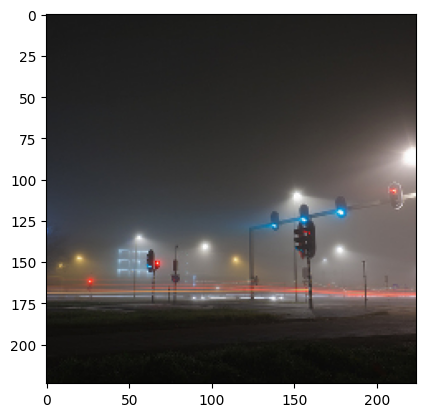

In [50]:
import matplotlib.pyplot as plt
import numpy as np

img_list_1 = train_dataset_transformed[81]['pixel_values']
caption_1 = train_dataset_transformed[81]['caption']
img_np_1 = np.array(img_list_1)
img_np_1 = img_np_1.transpose(1,2,0)
plt.imshow(img_np_1)

In [54]:
train_dataset.set_transform(transform_images)

In [55]:
train_dataset_set_transform = train_dataset

True

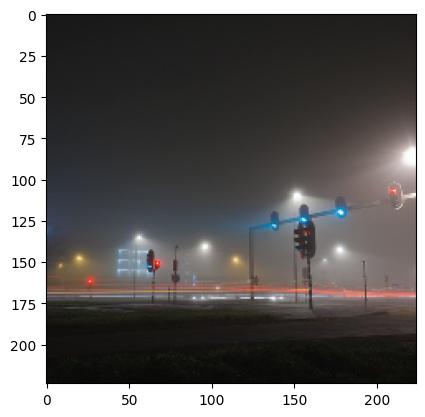

In [64]:
import matplotlib.pyplot as plt
import numpy as np

img_list_set_transform = train_dataset_set_transform[81]['pixel_values']
caption_set_transform = train_dataset_set_transform[81]['caption']
img_np_set_transform = np.array(img_list_set_transform)
img_np_set_transform = img_np_set_transform.transpose(1,2,0)
plt.imshow(img_np_set_transform)

np.array_equal(img_np_set_transform,img_np_1)


In [65]:
def add_random_noises(examples):
        device = "cuda"
        import torch
        if not isinstance(examples['pixel_values'],torch.Tensor):
            if isinstance(examples['pixel_values'][0],torch.Tensor):
                pixel_values = torch.stack(examples["pixel_values"]).to(device)
            else:
                pixel_values = torch.tensor(examples["pixel_values"], dtype=torch.float).to(device) 
        else:
            pixel_values = examples["pixel_values"].to(device)
        batch_size = pixel_values.shape[0]
        batch_shape = pixel_values.shape
        batch_noise = torch.randn(batch_shape).to(device)
        
        norm_type = 'l2'
        epsilon = 16
        if norm_type == 'l2':
            temp = torch.norm(batch_noise.view(batch_noise.shape[0], -1), dim=1).view(-1, 1, 1, 1)
            batch_noise = batch_noise * epsilon / temp
        else:
            batch_noise = torch.clamp(batch_noise, -epsilon / 255, epsilon / 255)

        # def random_noise(self, noise_shape=[10, 3, 32, 32]):
        # random_noise = torch.FloatTensor(*batch_shape).uniform_(-epsilon/255, epsilon/255).to(device)
        # batch_noise = random_noise 
            
        batch_image_with_noise = torch.clamp(batch_noise + pixel_values,0,1)  # Add noise , clamp to 0..1
        batch_pixel_with_noise_list = [batch_image_with_noise[i] for i in range(batch_image_with_noise.size(0))]
        examples["pixel_values"] = batch_pixel_with_noise_list
        return examples
    

In [85]:
train_dataset_random_noise = train_dataset_transformed.map(add_random_noises, batched=True, batch_size=64)

Map:   0%|          | 0/83 [00:00<?, ? examples/s]

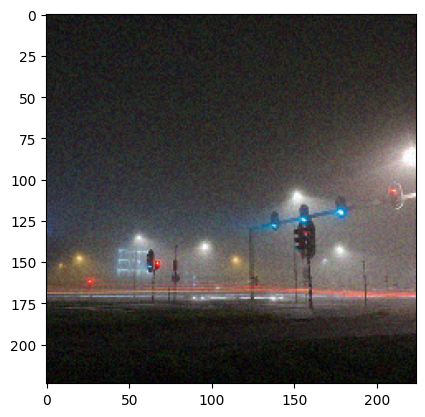

In [86]:
import matplotlib.pyplot as plt
import numpy as np

img_list_random_noise = train_dataset_random_noise[81]['pixel_values']
caption_random_noise = train_dataset_random_noise[81]['caption']
img_np_random_noise = np.array(img_list_random_noise)
img_np_random_noise = img_np_random_noise.transpose(1,2,0)
plt.imshow(img_np_random_noise)

In [87]:
(img_np_1==img_np_random_noise).all()

False

In [99]:
train_dataset_generate_noise = train_dataset_transformed.map(add_noises, batched=True, batch_size=64)

07/12/2023 22:04:27 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /remote-home/songtianwei/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-6f3462d26b47c55a/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f/cache-d361fc4c089da896.arrow


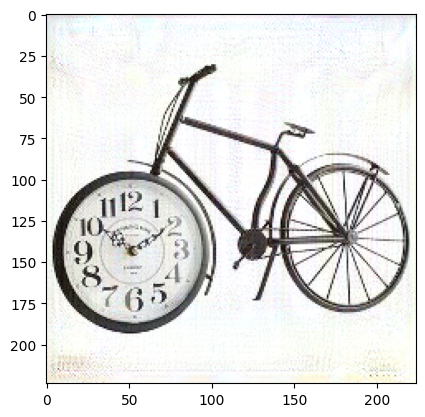

In [102]:
import matplotlib.pyplot as plt
import numpy as np

img_list_generate_noise = train_dataset_generate_noise[0]['pixel_values']
caption_generate_noise = train_dataset_generate_noise[0]['caption']
img_np_generate_noise = np.array(img_list_generate_noise)
img_np_generate_noise = img_np_generate_noise.transpose(1,2,0)
plt.imshow(img_np_generate_noise)

In [126]:
train_dataset = train_dataset.map(normalize_fn, batched=True, batch_size=64)

07/08/2023 20:43:34 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /remote-home/songtianwei/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-6f3462d26b47c55a/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f/cache-06346856a15b8fa2.arrow


In [127]:
for data in train_dataset:
    # print(data)
    caption = data['caption']
    pixel_values = data['pixel_values']
    print(caption)
    import numpy as np
    print(type(pixel_values))
    # print(pixel_values[0])
    print(np.array(pixel_values).shape)	
    input_ids = data['input_ids']
    print(input_ids)
    break

A bicycle replica with a clock as the front wheel.
<class 'list'>
(3, 224, 224)
[0, 250, 14678, 24633, 19, 10, 6700, 25, 5, 760, 5964, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


07/08/2023 20:43:37 - WARNING - matplotlib.image - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


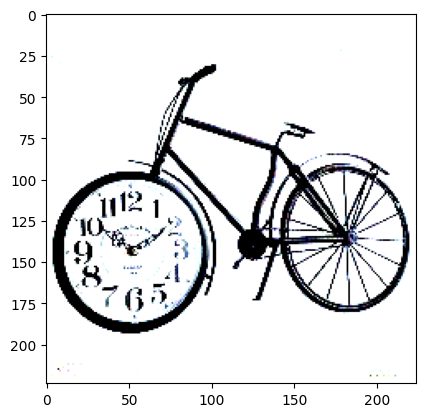

In [128]:
import matplotlib.pyplot as plt
import numpy as np

img_list = train_dataset[0]['pixel_values']
caption = train_dataset[0]['caption']
img_np = np.array(img_list)
img_np = img_np.transpose(1,2,0)
plt.imshow(img_np)

In [71]:
# train_dataset.save_to_disk(save_path)  # Goes wrong

Solved the problem: the process will stuck at the beginning. 

Methods:  If batched is True, default will use all dataset,  batch_size !!!

In [34]:

if training_args.do_train:
    if "train" not in dataset:
        raise ValueError("--do_train requires a train dataset")
    train_dataset = dataset["train"]
    if data_args.max_train_samples is not None:
        max_train_samples = min(len(train_dataset), data_args.max_train_samples)
        train_dataset = train_dataset.select(range(max_train_samples))

    train_dataset = train_dataset.filter(
        filter_corrupt_images, batched=True, num_proc=data_args.preprocessing_num_workers
    )
    train_dataset = train_dataset.map(
        function=tokenize_captions,
        batched=True,
        remove_columns=[col for col in column_names if col != image_column and col != caption_column],
        num_proc=data_args.preprocessing_num_workers,
        load_from_cache_file=not data_args.overwrite_cache,
        desc="Running tokenizer on train dataset",
    )

    # Transform images on the fly as doing it on the whole dataset takes too much time.
    # train_dataset.set_transform(transform_images)  WRONG!!!!!!!!!
    train_dataset = train_dataset.map(
        function=transform_images,
        batched=True,
        batch_size=64,
        num_proc=data_args.preprocessing_num_workers,
        load_from_cache_file=False,
        desc="Running transform on train dataset",
    )
    
    # set format to torch
    # train_dataset = train_dataset.with_format("torch")  Type not corresponding
    
    if data_args.dataset_noise_type is not None:
        logging.info(f"Adding noise to the dataset with noise type: {data_args.dataset_noise_type}")
        if data_args.dataset_noise_type == "random":
            print("Adding random noise")
            train_dataset = train_dataset.map(
                function=add_random_noises,
                batched=True,
                batch_size=64,
                num_proc=data_args.preprocessing_num_workers,
                load_from_cache_file=not data_args.overwrite_cache,
                desc="Running adding random noise on train dataset"
            ) 
        elif data_args.dataset_noise_type == "clip_min_noise":
            # add noise    
            print("Adding clip_min_noise")
            train_dataset = train_dataset.map(
                function=add_noises,
                batched=True,
                batch_size=64,
                num_proc=data_args.preprocessing_num_workers,
                load_from_cache_file=not data_args.overwrite_cache,
                desc="Running adding generated noise on train dataset"
            ) 
        else:
            raise ValueError(f"Unknown noise type: {data_args.dataset_noise_type}")
    else:
        logging.info(f"No noise is added to the dataset")
        
    if data_args.dataset_normalize_flag:
        # normalize
        logging.info(f"Normalizing the dataset")
        train_dataset = train_dataset.map(
            function=normalize_fn,
            batched=True,
            batch_size=64,
            num_proc=data_args.preprocessing_num_workers,
            load_from_cache_file=not data_args.overwrite_cache,
            desc="Running normalize on train dataset"
        )  
    else:
        logging.info(f"No normalization is added to the dataset")

07/19/2023 08:01:22 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /remote-home/songtianwei/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-6f3462d26b47c55a/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f/cache-44f9a38a37fbdd3d.arrow
07/19/2023 08:01:22 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /remote-home/songtianwei/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-6f3462d26b47c55a/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f/cache-5f5b0ecc30bb8c5e.arrow


Running transform on train dataset:   0%|          | 0/83 [00:00<?, ? examples/s]

Adding clip_min_noise
07/19/2023 08:01:34 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /remote-home/songtianwei/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-6f3462d26b47c55a/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f/cache-d361fc4c089da896.arrow


In [35]:


if training_args.do_eval:
    if "validation" not in dataset:
        raise ValueError("--do_eval requires a train validation")
    eval_dataset = dataset["validation"]
    if data_args.max_eval_samples is not None:
        max_eval_samples = min(len(eval_dataset), data_args.max_eval_samples)
        eval_dataset = eval_dataset.select(range(max_eval_samples))

    eval_dataset = eval_dataset.filter(
        filter_corrupt_images, batched=True, num_proc=data_args.preprocessing_num_workers
    )
    eval_dataset = eval_dataset.map(
        function=tokenize_captions,
        batched=True,
        num_proc=data_args.preprocessing_num_workers,
        remove_columns=[col for col in column_names if col != image_column],
        load_from_cache_file=not data_args.overwrite_cache,
        desc="Running tokenizer on validation dataset",
    )

    # Transform images on the fly as doing it on the whole dataset takes too much time.
    eval_dataset.set_transform(transform_images)

if training_args.do_predict:
    if "test" not in dataset:
        raise ValueError("--do_predict requires a test dataset")
    test_dataset = dataset["test"]
    if data_args.max_eval_samples is not None:
        max_eval_samples = min(len(test_dataset), data_args.max_eval_samples)
        test_dataset = test_dataset.select(range(max_eval_samples))

    test_dataset = test_dataset.filter(
        filter_corrupt_images, batched=True, num_proc=data_args.preprocessing_num_workers
    )
    test_dataset = test_dataset.map(
        function=tokenize_captions,
        batched=True,
        num_proc=data_args.preprocessing_num_workers,
        remove_columns=[col for col in column_names if col != image_column],
        load_from_cache_file=not data_args.overwrite_cache,
        desc="Running tokenizer on test dataset",
    )

    # Transform images on the fly as doing it on the whole dataset takes too much time.
    test_dataset.set_transform(transform_images)

07/19/2023 08:01:34 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /remote-home/songtianwei/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-6f3462d26b47c55a/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f/cache-df5777364e1d24b5.arrow
07/19/2023 08:01:34 - WARNING - datasets.arrow_dataset - Loading cached processed dataset at /remote-home/songtianwei/.cache/huggingface/datasets/ydshieh___coco_dataset_script/2017-6f3462d26b47c55a/0.0.0/e033205c0266a54c10be132f9264f2a39dcf893e798f6756d224b1ff5078998f/cache-efc09a1c9c4dbfa4.arrow


## 8. Initalize our trainer

In [36]:
pixel_values = torch.stack([example["pixel_values"] for example in examples])

NameError: name 'examples' is not defined

In [69]:
def collate_fn(examples):
    if torch.is_tensor(examples[0]["pixel_values"]):
        pixel_values = torch.stack([example["pixel_values"] for example in examples])
    else:
        pixel_values = torch.tensor([example["pixel_values"] for example in examples], dtype=torch.float)
    input_ids = torch.tensor([example["input_ids"] for example in examples], dtype=torch.long)
    attention_mask = torch.tensor([example["attention_mask"] for example in examples], dtype=torch.long)
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }

In [70]:


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset if training_args.do_train else None,
    eval_dataset=eval_dataset if training_args.do_eval else None,
    data_collator=collate_fn,
)

## 9. Training

In [71]:


if training_args.do_train:
    checkpoint = None
    if training_args.resume_from_checkpoint is not None:
        checkpoint = training_args.resume_from_checkpoint
    elif last_checkpoint is not None:
        checkpoint = last_checkpoint
    train_result = trainer.train(resume_from_checkpoint=checkpoint)
    trainer.save_model()
    tokenizer.save_pretrained(training_args.output_dir)
    image_processor.save_pretrained(training_args.output_dir)
    trainer.log_metrics("train", train_result.metrics)
    trainer.save_metrics("train", train_result.metrics)
    trainer.save_state()


/remote-home/songtianwei/conda/envs/pytorch2/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
[INFO|trainer.py:1672] 2023-07-19 08:13:30,348 >> ***** Running training *****
[INFO|trainer.py:1673] 2023-07-19 08:13:30,349 >>   Num examples = 83
[INFO|trainer.py:1674] 2023-07-19 08:13:30,349 >>   Num Epochs = 3
[INFO|trainer.py:1675] 2023-07-19 08:13:30,350 >>   Instantaneous batch size per device = 128
[INFO|trainer.py:1678] 2023-07-19 08:13:30,350 >>   Total train batch size (w. parallel, distributed & accumulation) = 128
[INFO|trainer.py:1679] 2023-07-19 08:13:30,350 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:1680] 2023-07-19 08:13:30,351 >>   Total optimization steps = 3
[INFO|trainer.py:1681] 2023-07-19 08:13:30,353 >>   Number o

AssertionError: 

## 10. Evaluation

In [72]:
if training_args.do_eval:
    metrics = trainer.evaluate()
    trainer.log_metrics("eval", metrics)
    trainer.save_metrics("eval", metrics)

[INFO|trainer.py:3085] 2023-07-19 08:13:49,978 >> ***** Running Evaluation *****
[INFO|trainer.py:3087] 2023-07-19 08:13:49,979 >>   Num examples = 25014
[INFO|trainer.py:3090] 2023-07-19 08:13:49,979 >>   Batch size = 64


KeyboardInterrupt: 

## 11. Write Training Stats and push to hub.

In [ ]:

kwargs = {"finetuned_from": model_args.model_name_or_path, "tasks": "contrastive-image-text-modeling"}
if data_args.dataset_name is not None:
    kwargs["dataset_tags"] = data_args.dataset_name
    if data_args.dataset_config_name is not None:
        kwargs["dataset_args"] = data_args.dataset_config_name
        kwargs["dataset"] = f"{data_args.dataset_name} {data_args.dataset_config_name}"
    else:
        kwargs["dataset"] = data_args.dataset_name

if training_args.push_to_hub:
    trainer.push_to_hub(**kwargs)
else:
    trainer.create_model_card(**kwargs)